<a href="https://colab.research.google.com/github/IgorJoaquimn/2023-TSP-Annealing/blob/main/Relatorio_TSP_GiovanaAssis_IgorJoaquim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introdução

O problema do Caixeiro Viajante é um desafio clássico em otimização. Sua relevância é inegável, devido à sua aplicação em uma ampla gama de campos, e sua complexidade é notória, uma vez que é classificado como NP-difícil. Em sua essência, o problema envolve encontrar a rota mais curta que permita a visita a um conjunto de cidades uma única vez e retornar à cidade de origem, com base nas distâncias entre as cidades.

O trabalho teve como objetivo principal comparar o desempenho do Simulated Annealing em diferentes cenários, variando o número de cidades, a distribuição das cidades e a complexidade das instâncias do problema. Os resultados obtidos permitiram avaliar a capacidade do Simulated Annealing em lidar com o problema do Caixeiro Viajante e forneceram insights valiosos sobre a influência dos parâmetros escolhidos no desempenho do método.

Nessa seção, apresentaremos um exemplo de como o método se comporta, usando como entrada pontos aleatórios:



In [ ]:
import time
start_time = time.time()

In [ ]:
import numpy as np
from numba import jit
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


In [ ]:
mark = (220/255, 100/255, 76/255)
line = (37/255, 5/255, 76/255)

##Ordenação

É sabido que métodos numéricos de otimização encontram o mínimo local mais próximo do ponto inicial, assim, a escolha de um bom ponto inicial - próximo do mínimo global - é de suma importância. Para isso, usamos uma heurística baseada na distribuição normal, onde a intuição principal vem do fato de que, se pares de pontos A e B possuem f(A) f(B) próximos, os pontos em si devem ser próximos. Assim, é tomada a função de distribuição de probabilidade para cada ponto na entrada e o caminho gerado é a ordenação desses pontos em relação a essas probabilidades.

In [ ]:
N = 1000
X = np.random.uniform(0,1,N).astype(float)
Y = np.random.uniform(0,1,N).astype(float)

pontos = np.array([X,Y]).T
dist = cdist(pontos,pontos,metric="euclidean")
rv = multivariate_normal([0, 0.5],np.cov(pontos.T)).pdf(pontos)
path = np.argsort(rv).astype(np.int16)


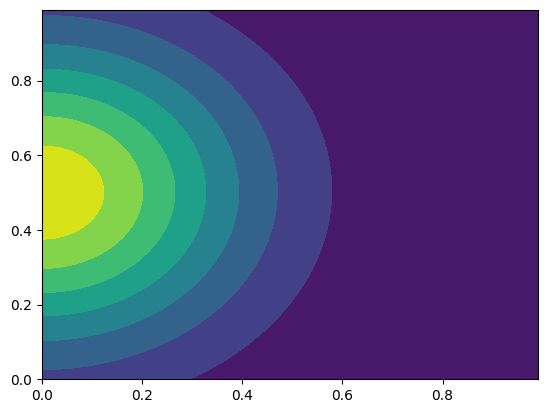

In [ ]:
x, y = np.mgrid[0:1:.01, 0:1:.01]
pos = np.dstack((x, y))
rv =  multivariate_normal([0, 0.5],np.cov(pontos.T))
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))

##Funções Auxiliares

Aqui estão as funções auxiliares necessárias para a execução do método. Observou-se uma notável melhoria no desempenho computacional ao utilizar a ferramenta "jit" (just-in-time compilation). Isso se deve ao fato de que essas funções são chamadas repetidamente, e a compilação prévia delas reduz significativamente o custo computacional.


In [ ]:
@jit(nopython=True)
def custo(N,path,dist):
    # calcula a distancia total percorrida pela caminhada
    ener = 0
    for i in range(N-1):
        ener += dist[path[i],path[i+1]]
    ener += dist[path[0],path[N-1]]     # conecta a última e a primeira cidades do caminho

    return ener

In [ ]:
@jit(nopython=True)
def newpath(N,path):
    newpath = np.zeros(N,dtype=np.int16)
    i=np.random.randint(N)   # escolhe uma posição aleatória da caminhada
    j=i
    while j==i:
        j=np.random.randint(N)  # escolhe outra posição
    if i>j:                    # ordena os índices
        ini = j
        fin = i
    else:
        ini = i
        fin = j

    for k in range(N):
      if ini <= k <= fin:
          newpath[k] = path[fin - k + ini]
      else:
          newpath[k] = path[k]

    return newpath, ini, fin

In [ ]:
@jit(nopython=True)
def one_repo(t_i,dt,t_final,step,en,best_e,best_p,path,dist):
  energy = []
  b_paths = []
  while(t_i > t_final):
    t_anterior = t_i
    t_i         = dt*t_anterior
    beta = 1/t_i
    for i in range(step):
      np1,ini,fin = newpath(N,path) # propoe um novo caminho

      esq = (ini-1) % N
      dir = (fin+1) % N

      de = -dist[path[esq],path[ini]] - dist[path[dir],path[fin]]+ dist[np1[esq],np1[ini]] + dist[np1[dir],np1[fin]]

      if de < 0:         # aplica o criterio de Metropolis
          en += de
          path = np1
          if en < best_e:  # guarda o melhor caminho gerado até o momento
              best_e = en
              best_p = path
              b_paths.append(path)
      else:              # aplica o criterio de Metropolis
          if np.random.random() < np.exp(-beta*de):
            en += de
            path = np1
      energy.append(en)
  return best_e,best_p,energy,b_paths

In [ ]:
en = custo(N,path,dist)
best_e = en
best_p = path
t_inicial = 1
t_i = t_inicial
dt = 0.99
t_final = 0.0001

step1 = 250
step2 = 250

##Análise da evolução da energia

In [ ]:
energy = []
b_paths = []
for i in range(5):
  best_e,best_p,eng,b_pathss = one_repo(t_i,dt,t_final,step1,en,best_e,best_p,path,dist)
  energy.append(eng)
  b_paths += b_pathss

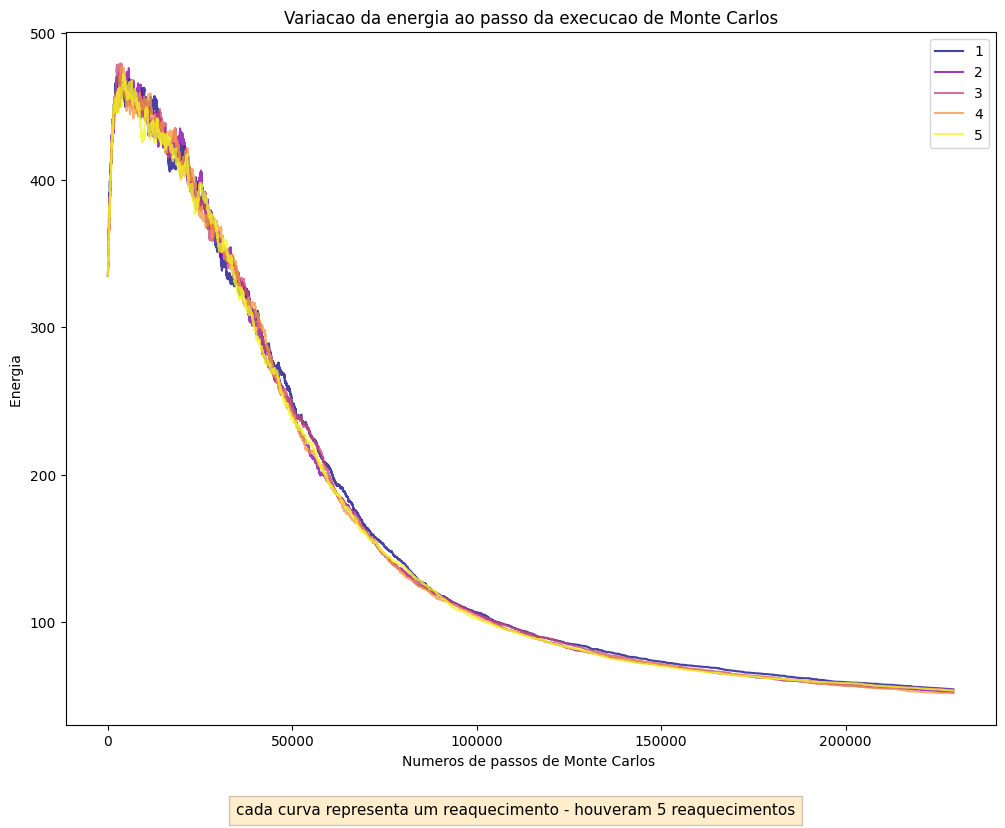

In [ ]:
plt.figure(figsize=(12,9))
plt.title("Variacao da energia ao passo da execucao de Monte Carlos")
plt.xlabel("Numeros de passos de Monte Carlos ")
plt.ylabel("Energia ")

colors = plt.cm.plasma(np.linspace(0, 1, len(energy)))
for i in range(len(energy)):
  sns.lineplot(x=list(range(len(energy[i]))), y = energy[i],color=colors[i],label=f"{i+1}",alpha=0.763)
plt.legend(loc="best")
plt.figtext(0.5, 0.01, "cada curva representa um reaquecimento - houveram 5 reaquecimentos", ha="center", fontsize=11, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
plt.show()



 **O gráfico acima** ilustra a evolução da energia do sistema à medida que os passos do algoritmo de Monte Carlo são executados. Inicialmente, consideramos temperaturas mais elevadas, o que resulta em uma maior probabilidade de aceitar um caminho que aumente a energia do sistema. Isso ocorre porque a função exponencial exp(-ΔE/T) diminui à medida que a temperatura diminui, sendo assim a probabilidade de aceitação se torna cada vez menor.

Essa tendência fica evidente no gráfico, onde na primeira parte é visível uma variação significativa na energia, com valores mais altos. No entanto, à medida que avançamos no gráfico, a energia se estabiliza gradualmente. Isso pode ser explicado pela diminuição da probabilidade de aceitar caminhos que aumentem a energia e pela escassez de trocas aleatórias que poderiam reduzir a energia à medida que nos aproximamos do ótimo local.




##Establidade do caminho

Outro fator a se considerar é o melhor caminho retornado pelo algoritmo. Pelo fato do algoritmo ser uma heurística, pode ocorrer o caso em que, a olho nu, exista um caminho muito melhor do que aquele retornado pelo programa, porém nunca chegou a ser montado pela caraterística aleatória do método. Assim, se mostra importante a visualização dos caminhos gerados, primeiramente, tomamos o caminho original:

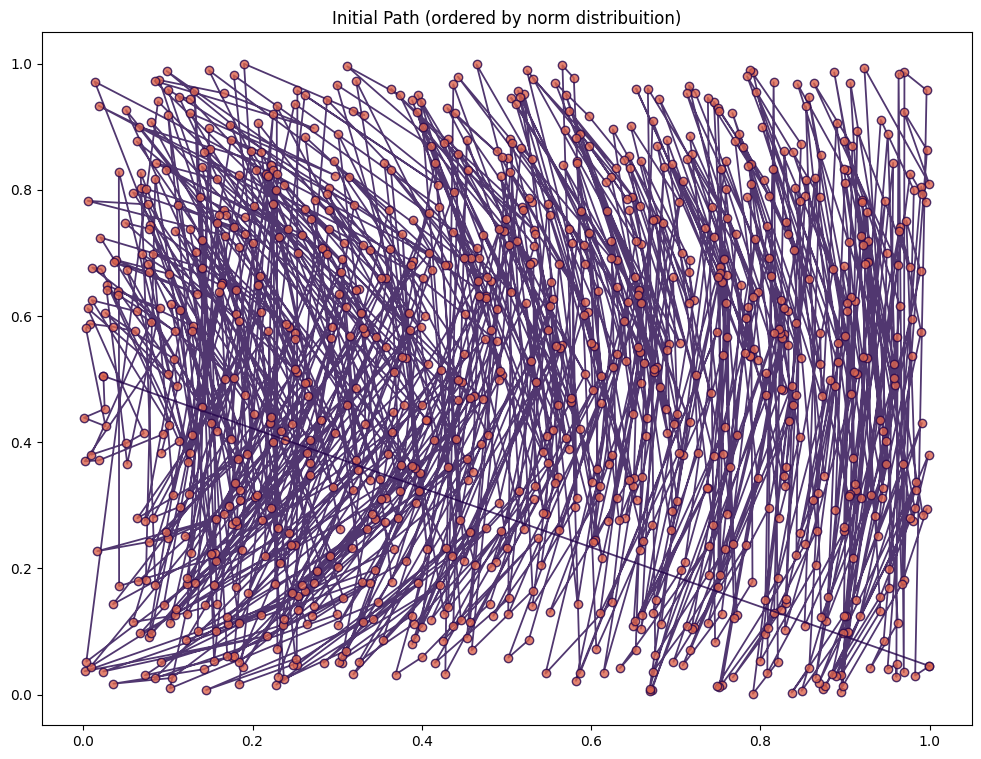

In [ ]:
plt.figure(figsize=(12,9))
plt.title("Initial Path (ordered by norm distribuition)")
plt.plot([X[i] for i in path], [Y[i] for i in path], marker='o', color=line, markersize=6, markerfacecolor=mark,linewidth=1.3,alpha=0.8)
plt.plot([X[path[0]],X[path[-1]]],[Y[path[0]],Y[path[-1]]], marker='o', color=line, markersize=6, markerfacecolor=mark,linewidth=1.3,alpha=0.8)


Podemos ver que o caminho inicial gerado forma uma estrutura cíclica e repetida, onde pontos no mesmo “anel” são vizinhos, essa consideração já diminui a energia do sistema.

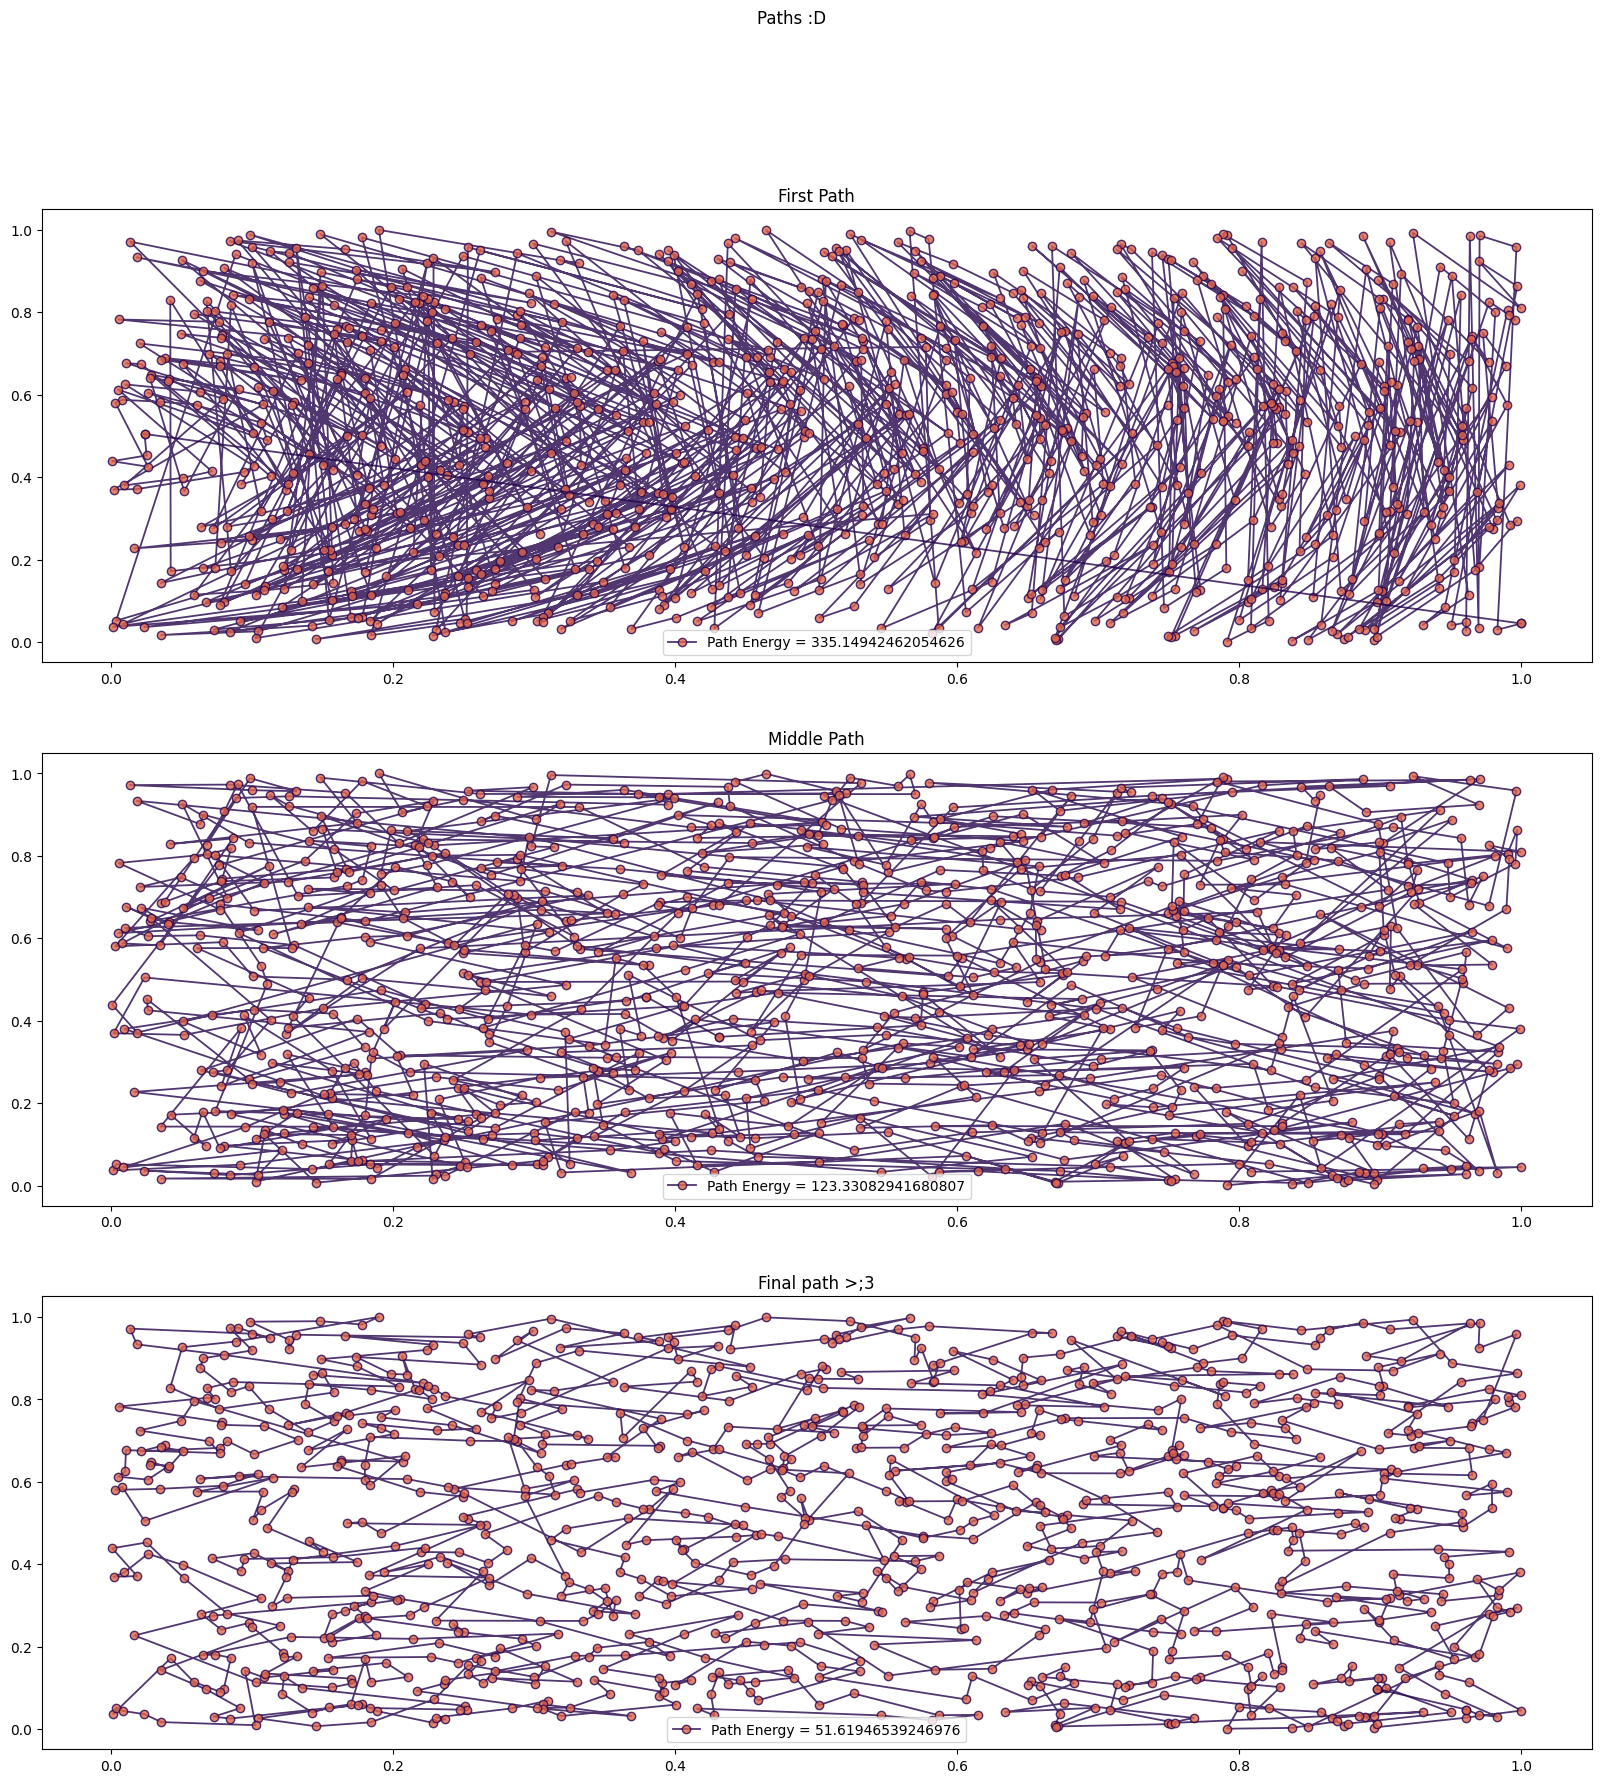

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 20))

# Set the title for the whole figure
fig.suptitle("Paths :D")

i_path = b_paths[0]
m_path = b_paths[len(b_paths)//2]
f_path = b_paths[-1]

# Plot the first path in the first subplot
axs[0].plot([X[i] for i in i_path], [Y[i] for i in i_path], marker='o', color=line, markersize=6, markerfacecolor=mark,linewidth=1.3,alpha=0.8)
axs[0].plot([X[i_path[0]], X[i_path[-1]]], [Y[i_path[0]], Y[i_path[-1]]], marker='o', color=line, markersize=6, markerfacecolor=mark,linewidth=1.3,alpha=0.8)
axs[0].set_title("First Path")
axs[0].legend([f"Path Energy = {custo(N, i_path, dist)}"], loc='lower center')

axs[1].plot([X[i] for i in m_path], [Y[i] for i in m_path], marker='o', color=line, markersize=6, markerfacecolor=mark,linewidth=1.3,alpha=0.8)
axs[1].plot([X[m_path[0]], X[m_path[-1]]], [Y[m_path[0]], Y[m_path[-1]]], marker='o', color=line, markersize=6, markerfacecolor=mark,linewidth=1.3,alpha=0.8)
axs[1].set_title("Middle Path")
axs[1].legend([f"Path Energy = {custo(N, m_path, dist)}"], loc='lower center')

# Plot the last path in the second subplot
axs[-1].plot([X[i] for i in f_path], [Y[i] for i in f_path], marker='o', color=line, markersize=6, markerfacecolor=mark,linewidth=1.3,alpha=0.8)
axs[-1].plot([X[f_path[0]], X[f_path[-1]]], [Y[f_path[0]], Y[f_path[-1]]], marker='o', color=line, markersize=6, markerfacecolor=mark,linewidth=1.3,alpha=0.8)
axs[-1].set_title("Final path >;3")
axs[-1].legend([f"Path Energy = {custo(N, f_path, dist)}"], loc='lower center')

# Display the figure
plt.show()

Com o passar da execução, uma estrutura maior se dá aos caminhos gerados. No primeiro caminho, nós próximos são conectados quase que formando vários “cliques”, evidenciadas pela alta taxa de sobreposição entre as arestas. Após algumas iterações, essa desordem diminui consistentemente até chegar em um estado bem mais lógico do que o inicial. Entretanto, vale notar que ainda existem regiões possíveis de aprimoramento, principalmente em situações onde pontos próximos não se interconectam, porém possuem vizinhos em comum, degenerando a estrutura do caminho.




##Conclusão

Concluindo, o Simulated Annealing mostrou uma abordagem promissora para abordar o problema do Caixeiro Viajante. Os resultados obtidos sugerem que, com uma configuração cuidadosa de parâmetros e um número suficiente de iterações, o algoritmo pode convergir para soluções de alta qualidade em baixo tempo computacional. No entanto, é fundamental reconhecer que o método é uma heurística, e a qualidade da solução final pode depender da escolha inicial e das configurações do algoritmo.

Além disso, a visualização dos caminhos gerados revela uma progressiva estabilização e otimização à medida que o Simulated Annealing é aplicado. Portanto, este estudo contribui para a compreensão do Simulated Annealing como uma ferramenta eficaz na resolução do Problema do Caixeiro Viajante e destaca a importância de explorar e ajustar os parâmetros do método, além de focar na eficiência computacional.

